# Learning a latent manifold on a noisy swiss roll

## Data set definition

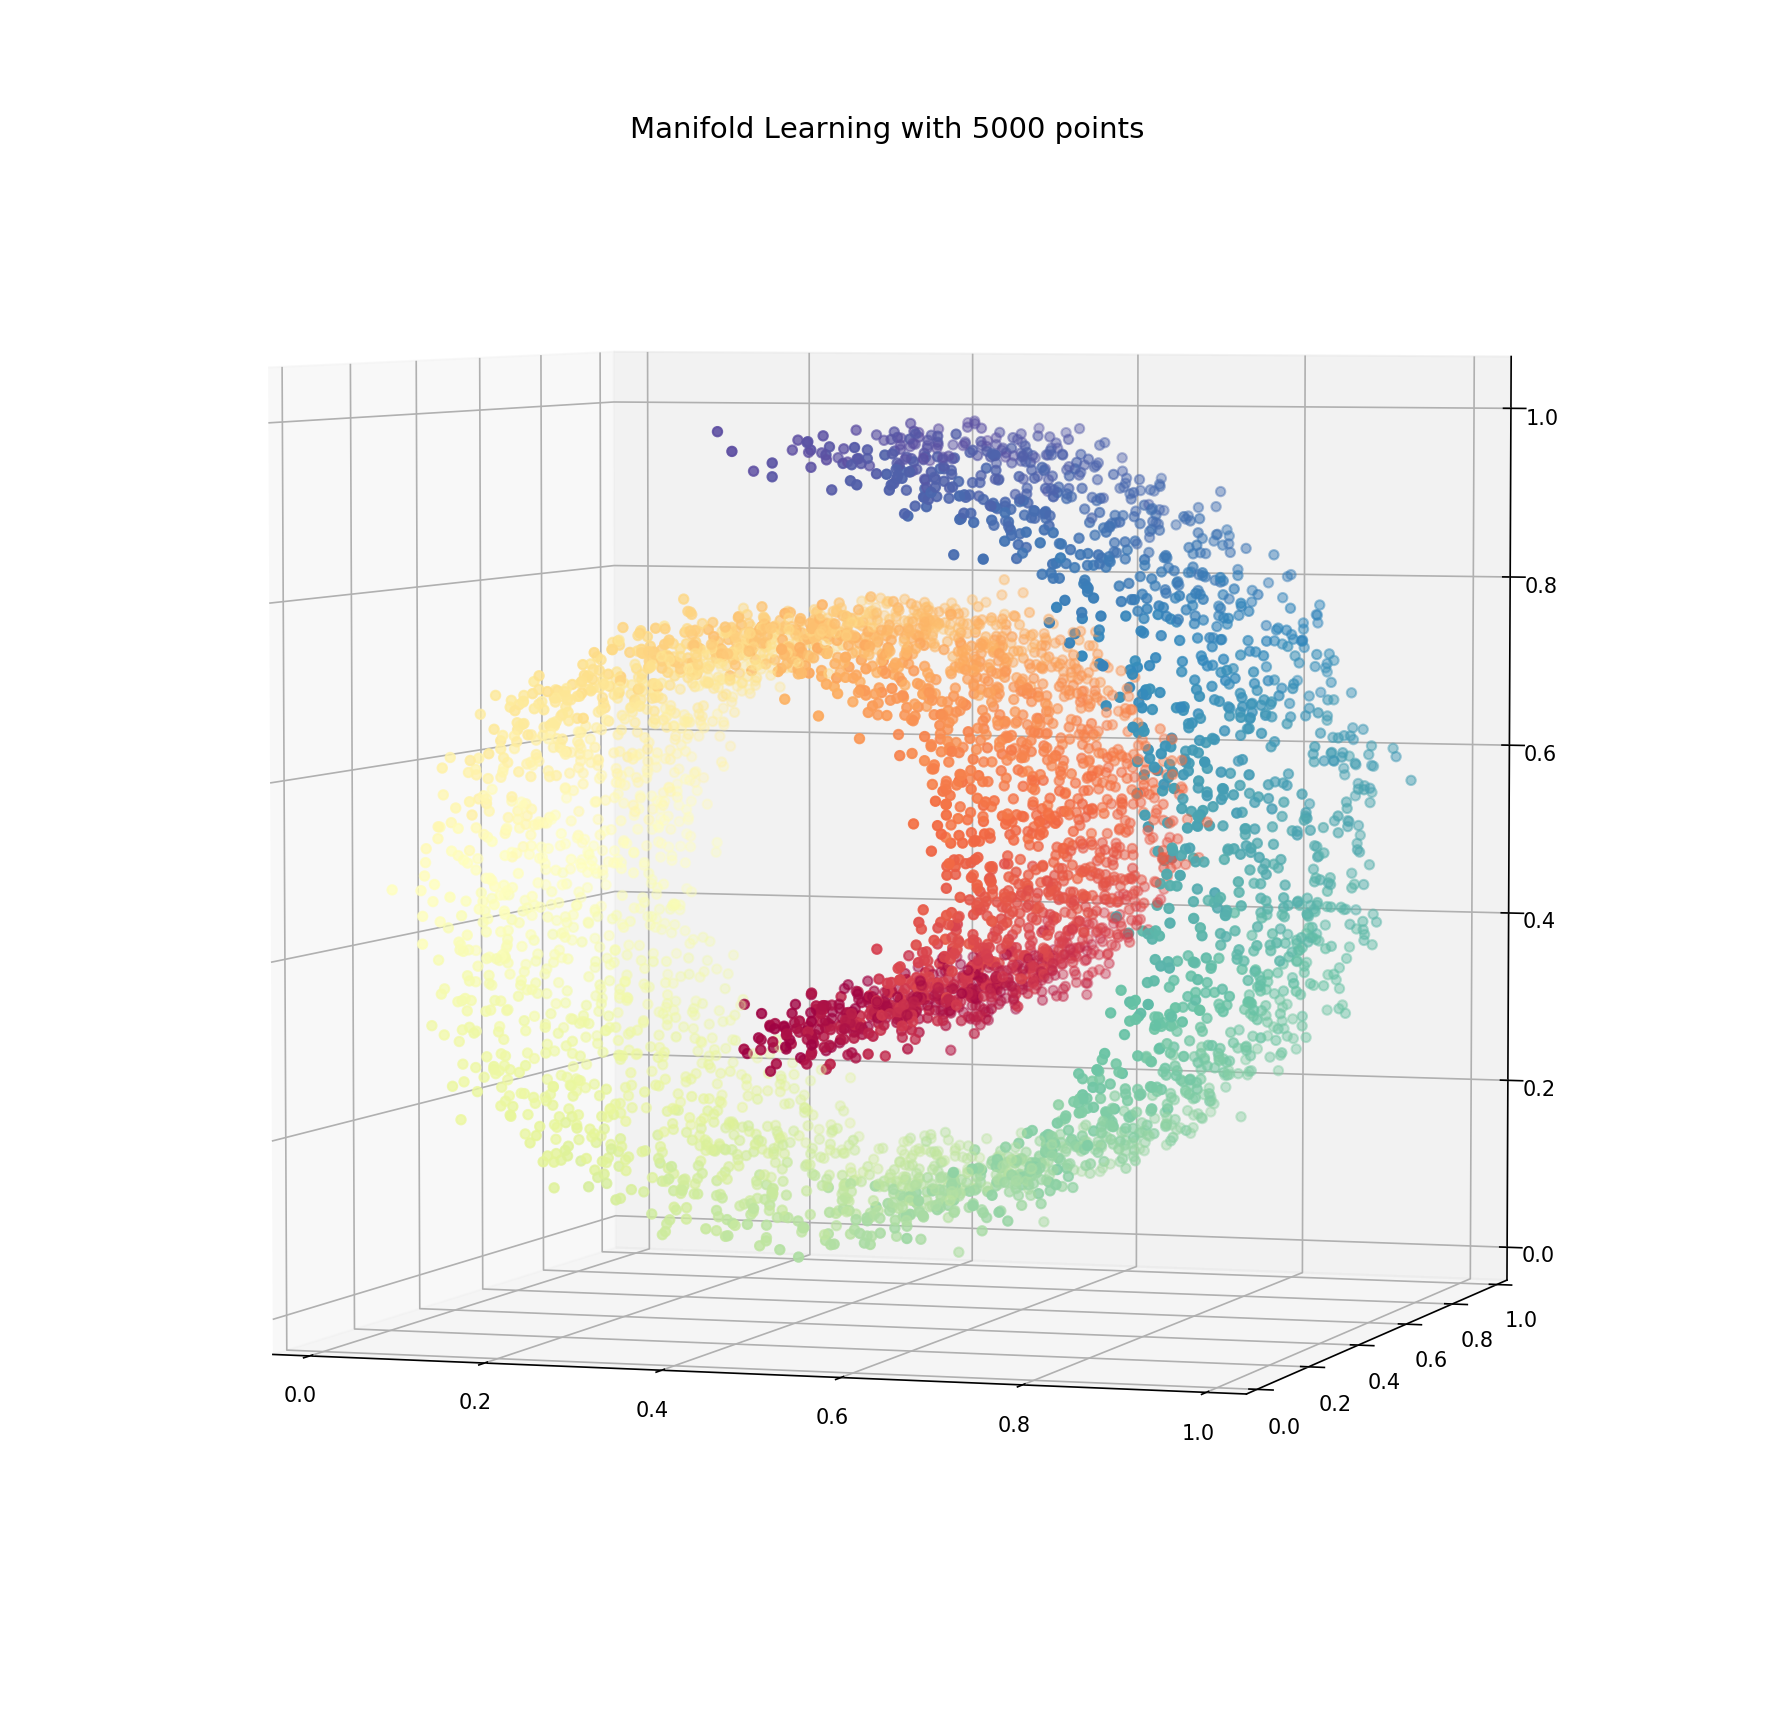

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.preprocessing as preprocessing
from sklearn import datasets
import numpy as np
import fnmatch

# Get scaled data set wrt. to the data set (X_aux) for the shortest-path proxy
n_aux_points = 5000
n_points = 5000
X_aux, _ = datasets.samples_generator.make_swiss_roll(n_aux_points, random_state=0, noise=0.7)
X, color = datasets.samples_generator.make_swiss_roll(n_points, random_state=0, noise=0.5)
X = np.concatenate((X_aux, X), axis=0)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0., 1.))
X = min_max_scaler.fit_transform(X)[n_aux_points:,:]

fig = plt.figure(figsize=(15, 15), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Manifold Learning with %i points"% (n_points), fontsize=14)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

## Define the VAE with its perceptual loss

In [2]:
# Disable graphic card
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import vae_tools.sanity
import vae_tools.viz
import vae_tools.vae
import vae_tools.callbacks
import keras.backend as K
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
from keras.layers import Input, Dense
import tensorflow as tf
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
from keras.models import load_model
from keras import metrics

z_dim = 2
intermediate_dim = 64
beta = 10.
epochs = 10000
batch_size = 64
weight = 6.
weight_mse = 12.

python version:  3.5.2
keras version: 2.3.0
tensorflow version: 1.14.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


Using TensorFlow backend.


## Defining the geodesic (aka perceptual) loss

The following def. is what we actually want to do: Defining a loss by a shortest-path algorithm.
However, this does not work since we cannot backprop through that kind of approach:

    class LosslayerReconstructionPath(vae_tools.vae.LosslayerReconstruction):
        '''Loss layer for element-wise path distance'''
    
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            self.n_neighbors = 5
            self.path_method = 'auto'
            self.neighbors_algorithm = 'auto'
            self.n_jobs = None
            # Should be the same as the training data set
            self.n_points = 1000
            self.X, _ = datasets.samples_generator.make_s_curve(self.n_points, random_state=0)
    
        def get_distance_matrix(self, X):
            # Costs alot cause the shortest path between all nodes is computed every time
            # Instead, we should only compute the path to x_decoded
            nbrs = NearestNeighbors(n_neighbors=self.n_neighbors,
                                          algorithm=self.neighbors_algorithm,
                                          n_jobs=self.n_jobs)
            nbrs.fit(X)
            kng = kneighbors_graph(nbrs, self.n_neighbors,
                                   mode='distance', n_jobs=self.n_jobs)
            G = graph_shortest_path(kng,
                                     method=self.path_method,
                                     directed=False)
    
            return G, kng, nbrs
        
        def get_distance(self, x, x_decoded):
            X = np.concatenate((self.X, list(x), list(x_decoded)))
            G, _, _ = self.get_distance_matrix(X)
            return G[-1, -2]
        
        def metric(self, x, x_decoded):
            return self.weight * self.get_distance(x, x_decoded)

Using a shortest-path proxy by means of a neuronal network does work.
Because now we can backprop the resulting gradient through this network.

tracking <tf.Variable 'Variable:0' shape=() dtype=float32> weight

tracking <tf.Variable 'Variable_1:0' shape=() dtype=float32> weight


/usr/local/lib/python3.5/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output loss_reconstruction_0_0 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to loss_reconstruction_0_0.
  'be expecting any data to be passed to {0}.'.format(name))
/usr/local/lib/python3.5/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output loss_prior_0 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to loss_prior_0.
  'be expecting any data to be passed to {0}.'.format(name))


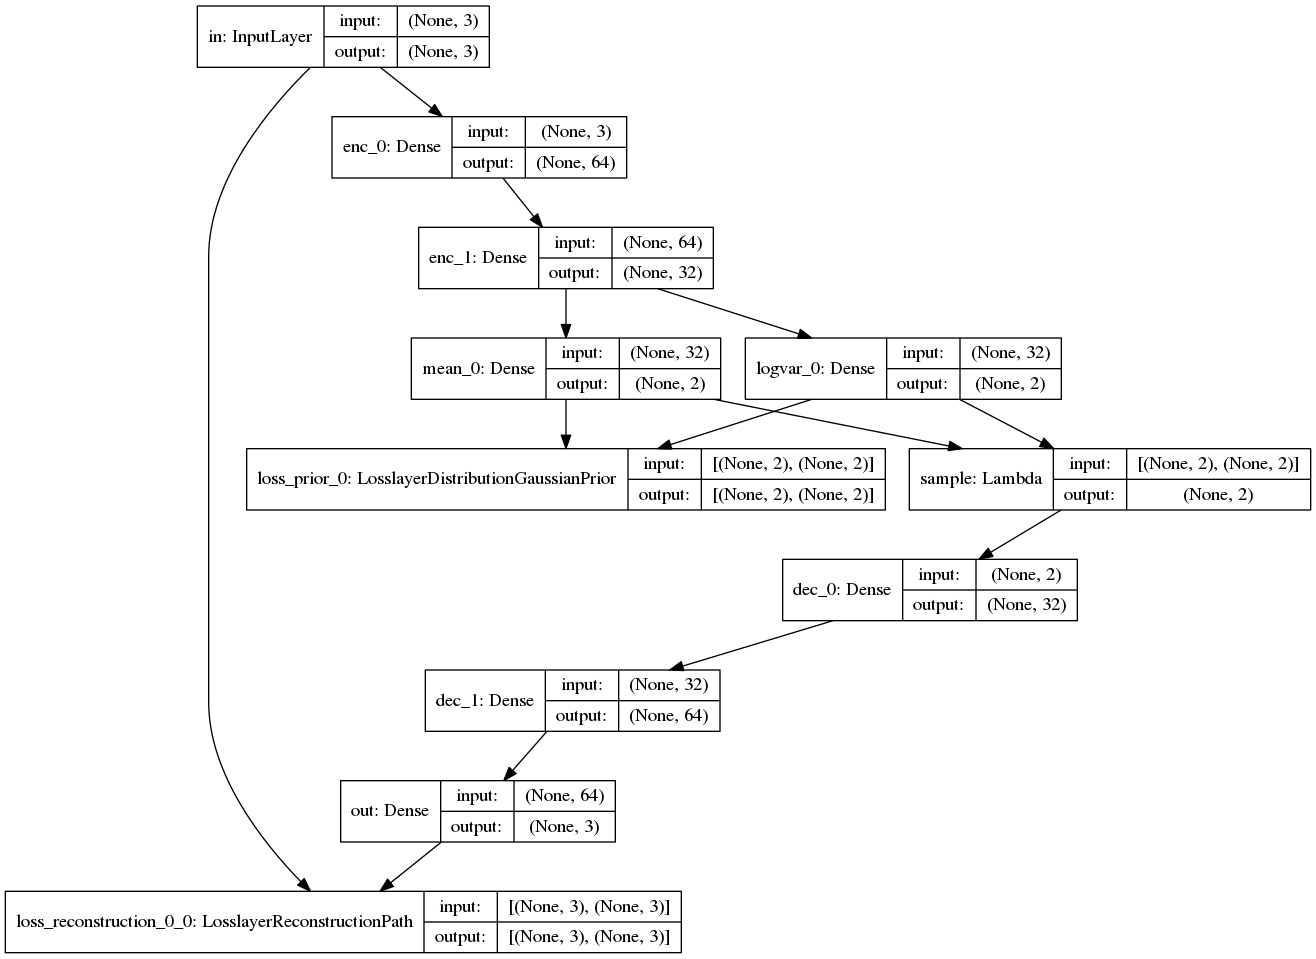

In [3]:
class LosslayerReconstructionPath(vae_tools.vae.LosslayerReconstruction):
    '''Loss layer for element-wise path distance'''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model = load_model('models/shortest_path_predictor_0to1.h5')
        self.model.trainable = False
        
    def get_sample(self, x_1, x_2): 
        x = tf.concat([x_1, x_2], axis=1)
        return x
    
    def get_distance(self, x, x_decoded):
        x_input = self.get_sample(x, x_decoded)
        dist = self.model(x_input)
        return dist
    
    def get_mse(self, x, x_decoded):
        x_input = self.get_sample(x, x_decoded)
        dist = self.model(x_input)
        return dist
    
    def metric(self, inputs):
        return K.sum(self.weight * (self.get_distance(inputs[0], inputs[1]))) + K.sum(weight_mse * metrics.mean_squared_error(inputs[0], inputs[1]))

encoder = [[
    Input(shape=(3,), name="in"),
    Dense(intermediate_dim, activation='elu', name="enc_0"),
    Dense(int(intermediate_dim/2), activation='elu', name="enc_1")
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='elu', name="dec_0"),
    Dense(intermediate_dim, activation='elu', name="dec_1"),
    Dense(3, activation='linear', name="out")
]]

model_name = "geodesic_vae"

vae_obj = MmVae(z_dim, encoder, decoder, [weight], 
                beta, beta_is_normalized = False,
                reconstruction_loss_metrics = [LosslayerReconstructionPath], name=model_name)

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = False)

In [4]:
# Train the network
vae.fit(X, shuffle=True, epochs=epochs, batch_size=batch_size,
        validation_data=None, verbose = 0)
# Show the losses
#vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)

## Show the resulting latent space

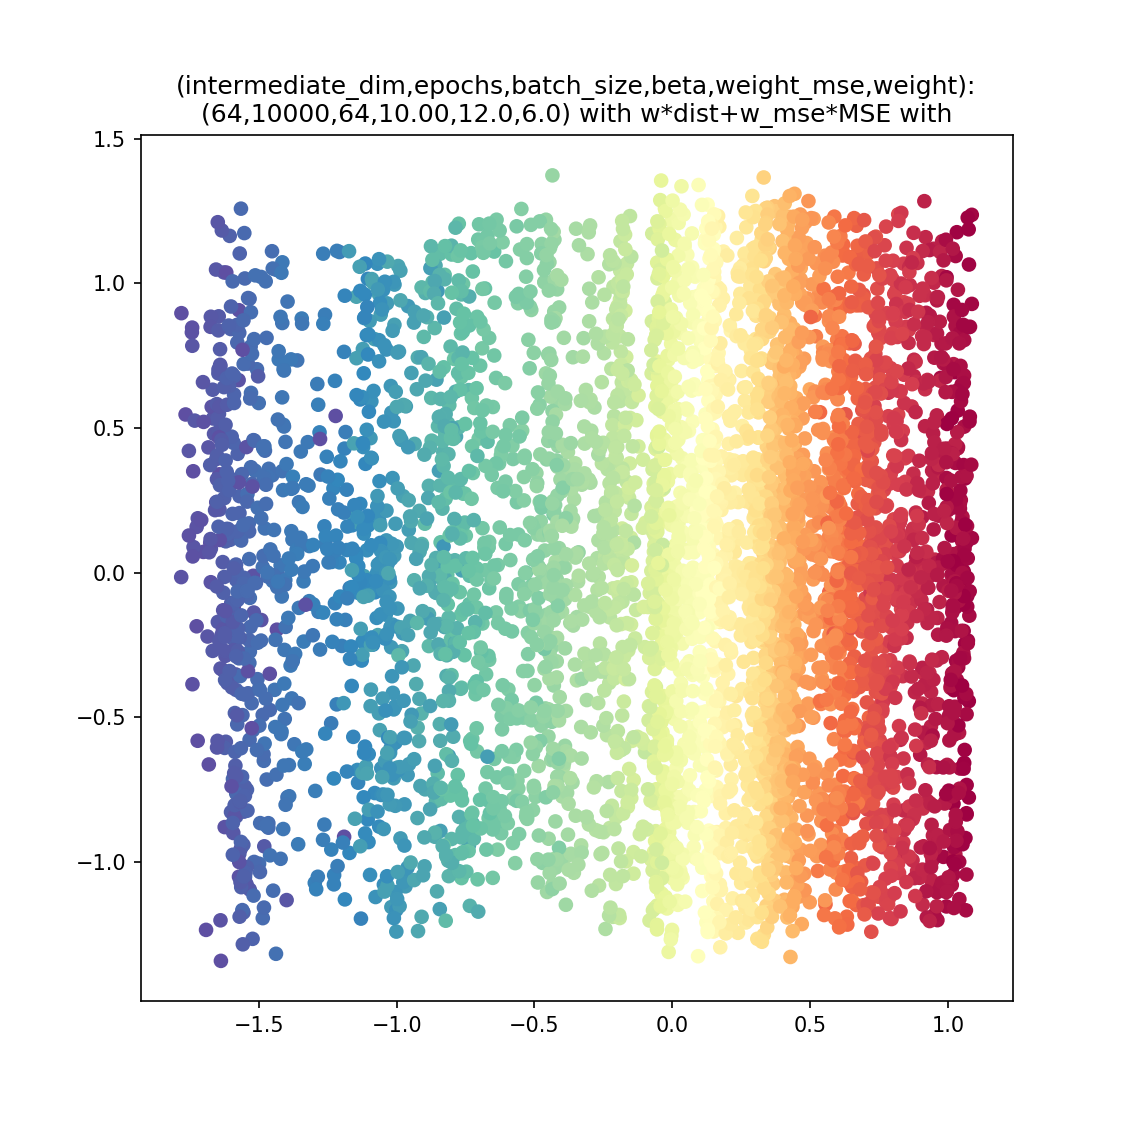

In [5]:
vae_enc = vae_obj.get_encoder_mean([encoder[0][0]])
x_enc = vae_enc.predict(X)

f, ax = plt.subplots(1,1,figsize=(10, 10), dpi=150)
ax.scatter(x_enc[:,0], x_enc[:,1], c=color, cmap=plt.cm.Spectral)
plt.title("(intermediate_dim,epochs,batch_size,beta,weight_mse,weight):\n (%i,%i,%i,%.2f,%.1f,%.1f) with w*dist+w_mse*MSE with "% (intermediate_dim,epochs,batch_size,beta,weight_mse,weight))

#plt.savefig('_' + str(len(fnmatch.filter(os.listdir("."), '*.png'))) + '.png')
plt.show()